# WestNileVirus

https://www.kaggle.com/c/predict-west-nile-virus

#### running the WNVscript.py that processes train and spray data into a clean and engineered dataset called: "sptrain"

In [1]:
# turn the expression into True to run the cell:
if 1==1:
    %run /Users/eran/Galvanize_more_repositories/WestNileVirus/WNVscript.py

In [2]:
sptrainW2.head(1)

,Longitude,Latitude,Date_of_collection,AddressAccuracy,NumMosquitos,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,...,ResultDir,AvgSpeed,weather_type_Norm,Day_of_month,month,year,Day_of_week,sprayed_2_yrs_ago,never_sprayed,WnvPresent
0,-87.705,41.883,2007-07-02,8,2,0,1,0,0,0,...,12,8.5,1,2,7,-1,0,0,1,0


In [10]:
import numpy as np
import pandas as pd
import statistics as st
import os

In [ ]:
pd.concat()

In [2]:
directory_path="/Users/eran/Galvanize_more_repositories/WestNileVirus/all/"
directory_path

'/Users/eran/Galvanize_more_repositories/WestNileVirus/all/'

## Train data

In [3]:
train_csv=os.path.join(directory_path, "train.csv")

In [4]:
# Reading in the train data
train=pd.read_csv(train_csv)

## EDA

### general info

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [6]:
train.head(3)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0


### Investigating specific columns: 'Species','Traps','AddressAccuracy' and Geo-location

In [7]:
train['Species'].unique() ## 6 different species

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [8]:
len(train['Trap'].unique()) ## 136 different traps

136

In [9]:
train['AddressAccuracy'].describe() ## this is (according to description) the accuracy as returned from geo-locator

count    10506.000000
mean         7.819532
std          1.452921
min          3.000000
25%          8.000000
50%          8.000000
75%          9.000000
max          9.000000
Name: AddressAccuracy, dtype: float64

In [10]:
train['AddressAccuracy'].hist() ## so most accuracy's are 8 and 9, some 5 and very little 3. 
# Later this could split into 3,4 categories and then into 3,4 dummie features 

#### ploting histogram (count) of count vs specie and whether there is WMV (color) 

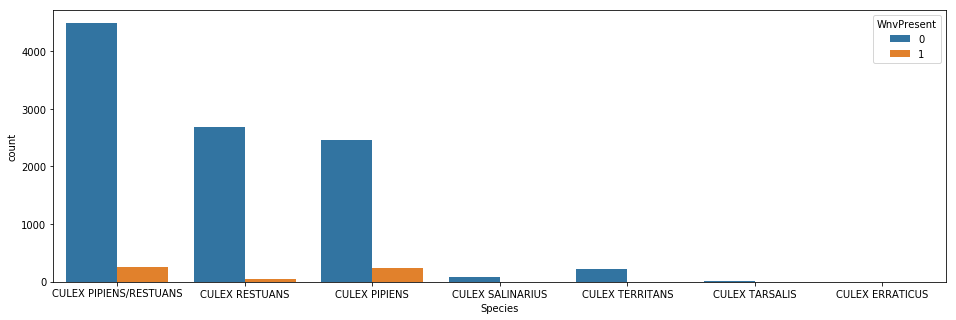

In [11]:
# looking at bars of every specie whether it has virus (orange) or not (blue)
# (to see if there is relationship between the species and the appearence of virus)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib  inline
dim=(16,5)
plt.subplots(figsize=dim)
sns.countplot('Species',data=train,hue='WnvPresent',)
# seems that only 3 species are really prevalent.
# "Culex Pipiens" has the highest relative portion of WNtV ~10% 

#### doing dummies out of species

In [12]:
# make new train with dummies
trainWdum=pd.get_dummies(train,columns=['Species'],drop_first=True)

In [13]:
trainWdum.describe()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,35.687797,41.841139,-87.699908,7.819532,12.853512,0.052446,0.256901,0.452313,0.260803,0.008186,0.000571,0.021131
std,24.339468,0.112742,0.096514,1.452921,16.133816,0.222936,0.436945,0.497744,0.439094,0.090109,0.023892,0.143827
min,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,41.846283,-87.694991,8.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### what about the geo-location feature?

In [14]:
# example of how many observation for 1 location:
df1location=trainWdum[(trainWdum['Latitude']==41.954690) & (trainWdum['Longitude']==-87.800991)]
len(df1location)

185

In [15]:
df1location.head(1)

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,0,1,0,0,0,0


In [16]:
## two rows in the train data: same date place etc. just the species are differen 
train.iloc[1]==train.iloc[0]


Date                       True
Address                    True
Species                   False
Block                      True
Street                     True
Trap                       True
AddressNumberAndStreet     True
Latitude                   True
Longitude                  True
AddressAccuracy            True
NumMosquitos               True
WnvPresent                 True
dtype: bool

In [17]:
df1location.tail(1)

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
10415,2013-09-26,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,8,0,1,0,0,0,0,0


In [18]:
# there are 185 records from the same location collected in 67 dates
len(df1location['Date'].unique())

67

### Getting baseline accuracy of predicting WNV 
let's understand the predictive capability of this data set without additional spreadsheets and without feature engineering:

In [19]:
trainBasic=trainWdum[['Latitude','Longitude','AddressAccuracy','NumMosquitos','Species_CULEX PIPIENS','Species_CULEX PIPIENS/RESTUANS','Species_CULEX RESTUANS','Species_CULEX SALINARIUS','Species_CULEX TARSALIS','Species_CULEX TERRITANS','WnvPresent']]

In [20]:
trainBasic.head(2)

,Latitude,Longitude,AddressAccuracy,NumMosquitos,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,WnvPresent
0,41.95469,-87.800991,9,1,0,1,0,0,0,0,0
1,41.95469,-87.800991,9,1,0,0,1,0,0,0,0


In [21]:
y=trainBasic['WnvPresent']
X=trainBasic.drop('WnvPresent',1)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
## stratify makes sure that ratio between classes stays like in the dataset

In [24]:
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression(random_state=42)
log_reg.fit(X_train,y_train)

In [24]:
pred=log_reg.predict(X_test)

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
target_names=['No Virus','Virus']
print(classification_report(y_test, pred, target_names=target_names))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,pred))
print("_____________________")
print("accuracy = ",round(accuracy_score(y_test,pred),3))

In [26]:
#               predicted.NO (-) predicted.Yes (+)
# actual NO (F)          1992            0
# actual Yes (T)          110            0

# accuracy = 1992/2102= 94.7% # (looking at all the predicted correctly - (TP+TN)/all )
# precision=0/0= 0  #(looking at predicted.yes column only)
# recall=0/110 = 0  #(looking at actual.yes column only)
# F1_score= 2/(1/0+1/0)=0  #2/(1/precision+ 1/recall) (weighted average between precision and recall) 

Accuracy is very high ~95% but this is because it's easy to predict that there is no virus because it's rare. but in cases where there is a virus, none were detected as we can see looking at the precision and recall equal to 0.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
yknn_pred=knn.predict(X_test)

In [28]:
print(classification_report(y_test, yknn_pred, target_names=target_names))
print(confusion_matrix(y_test,yknn_pred))
print("______________")
print("accuracy = ",round(accuracy_score(y_test,yknn_pred),3))

             precision    recall  f1-score   support

   No Virus       0.95      0.99      0.97      1992
      Virus       0.33      0.07      0.12       110

avg / total       0.92      0.94      0.93      2102

[[1976   16]
 [ 102    8]]
______________
accuracy =  0.944


In [21]:
from sklearn.metrics import f1_score
k_range=range(1,15)
accur=[]
f1list=[]
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred=knn.predict(X_test)
    acck=accuracy_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    accur.append(acck)
    f1list.append(f1)

Text(0,0.5,'f1_score')

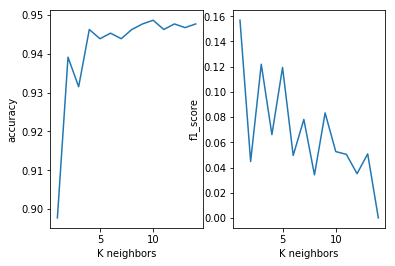

In [30]:
plt.subplot(1,2,1)
plt.plot(k_range,accur)
plt.xlabel('K neighbors')
plt.ylabel('accuracy')
plt.subplot(1,2,2)
plt.plot(k_range,f1list)
plt.xlabel('K neighbors')
plt.ylabel('f1_score')

because of the scarcity of incidence of WMV, the model is not better than a "dumb" model of predicting "No 
VIrus" every time 

We can see that after a certain point, increasing the bias (i.e."dumbing" the model, by using even higher kNeighbors) we don't see decrease in accuracy as we'd expect

f1_score (weighted average of precision and recall) is only dimished when the k are larger (meanning generalizing using higher K's) only decreases performance')  

#### we need to enrich the data, using aditional data sets..
later we will also have to deal with the imbalanced data set (scarce WMV=1 response rate)

## Spray data

### EDA

In [31]:
spray_csv=os.path.join(directory_path,"spray.csv")

In [32]:
spray=pd.read_csv(spray_csv)

In [33]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [34]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null object
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


It seems that there are nulls in the df in the Time column. We will see if will need to attend to that later.

how many days did they spray around?

In [337]:
spray['Date'].unique()

array(['2011-08-29T00:00:00.000000000', '2011-09-07T00:00:00.000000000',
       '2013-07-17T00:00:00.000000000', '2013-07-25T00:00:00.000000000',
       '2013-08-08T00:00:00.000000000', '2013-08-15T00:00:00.000000000',
       '2013-08-16T00:00:00.000000000', '2013-08-22T00:00:00.000000000',
       '2013-08-29T00:00:00.000000000', '2013-09-05T00:00:00.000000000'], dtype='datetime64[ns]')

Sprayed in ten different days.

### Using the Spray dataset 

#### Rational: 
#### assumption - recently sprayed areas would most likely reduce frequency in WNV for the same season. 
If Chicago Municipality, would like to know how to allocate sparying efforts (or any other eradication efforts for that matter), we should filter out the effect of recent spraying from our predictive model, as it is target-linked.
#### Method: find obsevations (collections on Train data) with locations that have been sprayed in the past 150 days ( length of a season of collection from May to Oct), and exclude them from the data sets used for modelling 

_________________________________________________________

#### Merging the spray and train data

because geo-location has such high resolution, we can't find matches between the data sets (which doesn't allow us to merge the tables accordingly). so 3 digits after the point seems reasonable - equates to 100 meters in resolution ( according to quick exploration on google maps: .001 ~=100 Meters)

In [39]:
# SPRAY DATA round longitude /latitude to 3 digits after the point
sprayR3=spray
sprayR3['Longitude']=sprayR3['Longitude'].round(3)
sprayR3['Latitude']=sprayR3['Latitude'].round(3)

In [51]:
# similarly, round the geo-location in the train data
# TRAIN with Dummies Data - round geo-location to 3 after the point. 
trainWdumR3=trainWdum
trainWdumR3['Longitude']=trainWdumR3['Longitude'].round(3)
trainWdumR3['Latitude']=trainWdumR3['Latitude'].round(3)

every location has different NUMBER of collection dates (train data) and spray dates (spray data) so when merging, we would like to see collection dates that are recent to spray dates because they should have a strong effect on the response and we might want to eliminate this effect because of target link. 
How shall we locate them?

In [40]:
# first, how many entries per geo-location in spray data? 
sprayR3['longlat']=list(zip(sprayR3['Latitude'],sprayR3['Longitude'])) # zip log and lat into one column
grp=sprayR3.groupby(['longlat'])['Date'].count() # count for every location the different number of dates
print(grp.describe()) # for each location, how many different dates it got sprayed?

count    6517.000000
mean        2.276354
std         6.797308
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max       542.000000
Name: Date, dtype: float64


So, 75% of locations where sprayed at most 3 times. 
Let's get more specific, what is the gap between 1st and last spray dates for a specific location?

In [151]:
sprayR3['Date']=pd.to_datetime(sprayR3['Date']) ## change to datetime object so operations could be done
type(sprayR3['Date'][0])

pandas._libs.tslib.Timestamp

In [42]:
aggd=sprayR3.groupby(['longlat'])['Date'].agg([np.ptp]) ## group by longlat and on the dates, get the range (max-min)
aggd=aggd.sort_values('ptp',ascending=False) 
print(aggd.head(3))

                       ptp
longlat                   
(41.997, -87.811) 729 days
(41.954, -87.784)   1 days
(41.911, -87.75)    1 days


In [43]:
oldaggd=aggd[aggd['ptp'].dt.days>150]
oldaggd.head()

,ptp
longlat,
"(41.997, -87.811)",729 days


so only one place was sprayed more than 150 days appart (and actually this place was the only one with more than 1 day appart..), so effectively only one place was sprayed more than once.
how many times it was sprayed?

In [44]:
sprayR3[sprayR3['longlat']==(41.997, -87.811)]

,Date,Time,Latitude,Longitude,longlat
1454,2011-09-07,NaN,41.997,-87.811,"(41.997, -87.811)"
1455,2011-09-07,NaN,41.997,-87.811,"(41.997, -87.811)"
14664,2013-09-05,7:51:11 PM,41.997,-87.811,"(41.997, -87.811)"


Twice, 2 years appart.  

what about all the other sites how many days appart where they sprayed?

In [45]:
recaggd=aggd[aggd['ptp'].dt.days!=729] ## excluding that one outlier
recaggd['ptp'].value_counts()

0 days    6511
1 days       5
Name: ptp, dtype: int64

sites were sprayed 1 day apart at most, only 5 sites where sprayed throughout 2 days.
This is an insignificant ammount, so essentially if we aggregate the spray by geo-location we can merge it with train, and not worry about duplicates.

(we can do it because we assume that the time stamp of spraying is not informative and produces redundant data. e.g. spraying at 11:58 PM, then at 12:04 AM (the next day) a few meters away with changes in geo-location (before rounding it when the Longitude and Latitude where 10^-6 resolution)

####  Grouping Data from spray 
instead of merging spray data directly

Let's create a new df from spray, to merge later with train data.
the new df will be grouped by geo-location, and the dates of collection would be aggregated and investigated (e.g. to see how many sprayed occured in every location (count), what's the gap between 1st and last spray (ptp)..)

In [138]:
print(sprayR3.head(2))
sprayR3
ff=sprayR3.groupby(['Longitude','Latitude']).Date.agg(['count','min','max',np.ptp]).reset_index()
ff=ff.sort_values('ptp',ascending=False)
ff.head()

        Date        Time  Latitude  Longitude            longlat
0 2011-08-29  6:56:58 PM    42.392    -88.089  (42.392, -88.089)
1 2011-08-29  6:57:08 PM    42.391    -88.089  (42.391, -88.089)


,Longitude,Latitude,count,min,max,ptp
696,-87.811,41.997,3,2011-09-07,2013-09-05,729 days
1804,-87.784,41.957,3,2013-08-15,2013-08-16,1 days
1858,-87.783,41.965,3,2013-08-15,2013-08-16,1 days
2789,-87.750,41.911,2,2013-08-15,2013-08-16,1 days
1801,-87.784,41.954,4,2013-08-15,2013-08-16,1 days


In [136]:
print('len spray data',len(sprayR3))
print('unique spray data',sprayR3['longlat'].nunique())
print('len grouped long/lat spray data',len(ff))
ff['longlat']=list(zip(ff['Longitude'],ff['Latitude']))
print('unique grouped long/lat spray data',ff['longlat'].nunique())

len spray data 14835
unique spray data 6517
len grouped long/lat spray data 6517
unique grouped long/lat spray data 6517


In [244]:
res4=pd.merge(ff,trainWdumR3,on=['Longitude','Latitude'],how='right',indicator=True)
print(len(res4))
print(len(trainWdumR3))
res4.head(1)

10506
10506


,Longitude,Latitude,count,min,max,ptp,Date,Address,Block,Street,...,AddressAccuracy,NumMosquitos,WnvPresent,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,_merge
0,-87.705,41.883,3.0,2013-08-22,2013-08-22,0 days,2007-07-02,"3300 West Randolph Street, Chicago, IL 60612, USA",33,E RANDOLPH ST,...,8,2,0,0,1,0,0,0,0,both


 # 3 #

 # 3 #

Let's create a function that finds the days since the most recent spray, given a date of collection minus dates of spraying: 

In [6]:
def recent(delMin,delMax):
    if (delMin>=0) & (delMax<0):
        dell=delMin
    elif (delMax>=0) & (delMin<0):
        dell=delMax
    elif (delMax<0) & (delMin<0):
        dell=3650
    elif (delMax>=0) & (delMin>=0):
        if delMax<delMin:
            dell=delMax
        elif delMax>delMin:
            dell=delMin
        else:
            dell=delMin
    elif delMin.isnull() or delMax.isnull():
        dell=3650
    return(dell)

In [252]:
res4['Date']=pd.to_datetime(res4['Date'])

In [253]:
res4['delmin']=res4['Date']-res4['min']
res4['delmin']=res4['delmin'].dt.days
res4['delmax']=res4['Date']-res4['max']
res4['delmax']=res4['delmax'].dt.days

In [290]:
res4['most_recent_spray (days)']=res4.apply(lambda x: recent(x['delmin'],x['delmax']),axis=1)

Let's look at res4. after 962 obdservations with spray, the rest is without data on spray:

In [287]:
print(res4.shape)
res4.loc[962:963,:]

(10506, 24)


,Longitude,Latitude,count,min,max,ptp,Date,Address,Block,Street,...,WnvPresent,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,_merge,delmin,delmax
962,-87.788,41.970,2.0,2011-09-07,2011-09-07,0 days,2007-10-04,"6400 West Strong Street, Chicago, IL, USA",64,W STRONG ST,...,0,1,0,0,0,0,0,both,-1434.0,-1434.0
963,-87.801,41.955,NaN,NaT,NaT,NaT,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,...,0,0,1,0,0,0,0,right_only,NaN,NaN


Make an inner merge to concentrate on the spray&train intersection (and avoid dealing with NaT and NaN for now)

In [271]:
resIN=pd.merge(ff,trainWdumR3,on=['Longitude','Latitude'],how='inner',indicator=True)

In [272]:
resIN['Date']=pd.to_datetime(resIN['Date'])

In [274]:
resIN['delmin']=resIN['Date']-resIN['min']
resIN['delmin']=resIN['delmin'].dt.days
resIN['delmax']=resIN['Date']-resIN['max']
resIN['delmax']=resIN['delmax'].dt.days

use "recent" function (look previously) to be used again with apply and lambda to create a column of days since the most recent spray  

In [290]:
resIN['most_recent_spray (days)']=resIN.apply(lambda x: recent(x['delmin'],x['delmax']),axis=1)

#### Let's join the inner df (the merged grouped-spray data with train) and the rest of the train (without spray data), to make a new enriched df for modelling.

In [288]:
print(resIN.shape)
print(res4.shape)

(963, 25)
(10506, 24)


let's add a column to res4. 
Let's set a value for most recent spray at 3650 (10 yrs) to areas with no spray data, this is to avoid NaN and still put a big number to differntiate these cases from recently sprayed and up to several years sprayed before collection. 

In [292]:
res4['most_recent_spray (days)']=3650
res4['most_recent_spray (days)'].value_counts().head(3)

3650    10506
Name: most_recent_spray (days), dtype: int64

In [ ]:
Now conocat the dfs

In [339]:
res5=pd.concat([resIN,res4.loc[963:,:]])
res5.shape

(10506, 25)

now let's arrange the columns (delete and order)

In [340]:
colls=res5.columns
colls

Index(['Longitude', 'Latitude', 'count', 'min', 'max', 'ptp', 'Date',
       'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet',
       'AddressAccuracy', 'NumMosquitos', 'WnvPresent',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', '_merge', 'delmin',
       'delmax', 'most_recent_spray (days)'],
      dtype='object')

In [341]:
colis=list(colls)
print(colis)
colsnew=colis[:2]+colis[3:5]+[colis[-1]]+colis[6:14]+colis[15:21]+colis[14:15] 
print(colsnew)
res5=res5[colsnew]
res5.rename(columns={'Date':'Date_of_collection'},inplace=True)
res5.head(1)

['Longitude', 'Latitude', 'count', 'min', 'max', 'ptp', 'Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', '_merge', 'delmin', 'delmax', 'most_recent_spray (days)']
['Longitude', 'Latitude', 'min', 'max', 'most_recent_spray (days)', 'Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'AddressAccuracy', 'NumMosquitos', 'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'WnvPresent']


,Longitude,Latitude,min,max,most_recent_spray (days),Date_of_collection,Address,Block,Street,Trap,AddressNumberAndStreet,AddressAccuracy,NumMosquitos,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,WnvPresent
0,-87.705,41.883,2013-08-22,2013-08-22,3650,2007-07-02,"3300 West Randolph Street, Chicago, IL 60612, USA",33,E RANDOLPH ST,T044,"3300 E RANDOLPH ST, Chicago, IL",8,2,0,1,0,0,0,0,0


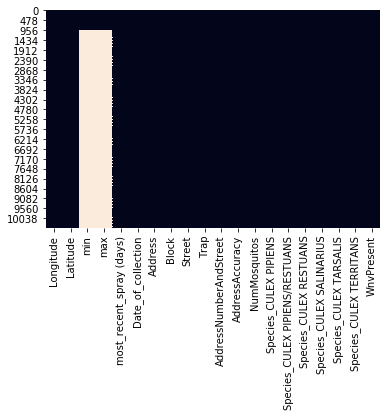

In [343]:
sns.heatmap(res5.isnull(),cbar=False) 
# the heatmap shows the 1st 962 of entries being sprayed data (rows in uniform black)
# the rest of the observations were not sprayed

####  finally let's see about our assumption (do areas that were recently sprayed have lower WNV frequency?

first let's isolate cases of recent spraying

In [1523]:
res5['most_recent_spray (days)'].value_counts().head(3)

3650    10400
7           8
28          6
Name: most_recent_spray (days), dtype: int64

In [1525]:
res5.shape

(10506, 21)

for places that where sprayed, what was the most recent spray? ( I have eliminated the 3650 (10yrs) for visualization purposes) 

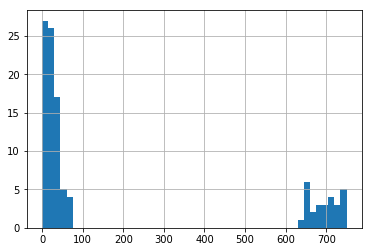

In [299]:
res5.loc[0:,'most_recent_spray (days)'][res5.loc[0:,'most_recent_spray (days)']<3650].hist(bins=50)

Seems like locations were either sprayed 2 years ago (around 700 days bars) or in this season (last 80 days).

This is the data that could be target link and we need to be cautious with.

In [331]:
recol=res5.loc[0:,'most_recent_spray (days)'][res5.loc[0:,'most_recent_spray (days)']<150]
recol.count()

79

there are 79 trap collections (entries) conducted recently after spraying (the same season <150 days). 

In [332]:
res5.loc[0:,'WnvPresent'][res5.loc[0:,'most_recent_spray (days)']<150].value_counts()

0    71
1     8
Name: WnvPresent, dtype: int64

####  surprisingly the frequency is higher 10%(8/79) in the recently sprayed data, than in the whole data combined ~5%.
This could have an alternative explanation: Places that are sprayed are proune to have WNV and therefore were a target for spraying in the first place.
This still shows that there is a target link. therefore these 79 cases should be taken care of in our modelling.

In [372]:
# let' add a column - whether the area was recently sprayed (i.e. <150 days)
res5['Recently_sprayed']=(res5['most_recent_spray (days)']<150).astype(int)
res5['Recently_sprayed'].value_counts()

0    10427
1       79
Name: Recently_sprayed, dtype: int64

#  # # # # 4

#### Let's do some EDA on the merged data in context of sprayed VS not sprayed

In [360]:
resin_copy=resIN.copy()

In [ ]:
plt.subplot(1,2,1)
plt.bar(['No','Yes'],[notspr[0],notspr[1]],color=['navy','orange'])
plt.title('Not Sprayed')
plt.subplot(1,2,2)
plt.bar(['Yes','No'],[spr[1],spr[0]],color=['orange','navy'])
plt.title('Sprayed')

In [ ]:
print("occurences of WNV in sprayed places:")
spr=resin_copy['WnvPresent'].value_counts()
print(spr)
print('percentage: ',spr[1]/(spr[0]+spr[1])*100)
notsprayed=resin_copy[resin_copy['Date_of_collection'].isnull()==1]
print("occurences of WNV in sprayed places:")
notspr=notsprayed['WnvPresent'].value_counts()
print(notspr)
print('percentage: ',notspr[1]/(notspr[0]+notspr[1])*100)
plt.subplot(1,2,1)
plt.bar(['No','Yes'],[notspr[0],notspr[1]],color=['navy','orange'])
plt.title('Not Sprayed')
plt.subplot(1,2,2)
plt.bar(['Yes','No'],[spr[1],spr[0]],color=['orange','navy'])
plt.title('Sprayed')

# # # # # 

## Weather data

### Background

From Kaggle:
    - It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. We provide you with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests.

From '/Users/eran/Galvanize_more_repositories/WestNileVirus/all/noaa_weather_qclcd_documentation.pdf':
    - Dew point is an accurate measurement of humidity (indipendant of Relative humidity) 60= uncomfortable, 70 very uncomfortable.
        https://minnesota.cbslocal.com/2012/07/17/good-question-whats-the-difference-between-dew-point-and-humidity/
    - M = missing data
    - "A lower wet bulb temperature means the air is drier and can hold more water vapor than it can at a higher wet bulb temperature."

### Rational
- Find columns directly related to Hot and Dry <-> higher WNV virus
- try to engineer them 
- merge according to proximity to weather station And Date

### EDA

In [363]:
weather_csv=os.path.join(directory_path,"weather.csv")
weather=pd.read_csv(weather_csv)
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: float64(1), int64(5), object(16)
memory usage: 506.1+ KB


In [406]:
weather.head(3)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4


In [433]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [365]:
weather['Station'].unique()
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

array([1, 2])

In [462]:
#dim=(16,5)
#plt.subplots(figsize=dim)
weather['Depart'][weather['Depart']!='M'].max(), weather['Depart'][weather['Depart']!='M'].min()

('23', ' 0')

In [463]:
weather['WetBulb'][weather['WetBulb']!='M'].max(), weather['WetBulb'][weather['WetBulb']!='M'].min()

('78', '32')

In [461]:
weather['Cool'][weather['Cool']!='M'].max(), weather['Cool'][weather['Cool']!='M'].min()

('29', ' 0')

In [561]:
print(type(weather.loc[122,'Sunrise'])) ## times are strings
sum(weather['Sunrise']=='-') ## alternating '-' 1472/2944

<class 'str'>


1472

In [520]:
weather[['Depart','WetBulb','Heat','Cool','Sunrise','CodeSum']].describe()

,Depart,WetBulb,Heat,Cool,Sunrise,CodeSum
count,2944,2944,2944,2944,2944,2944
unique,42,48,31,31,122,98
top,M,63,0,0,-,
freq,1472,135,1870,1147,1472,1609


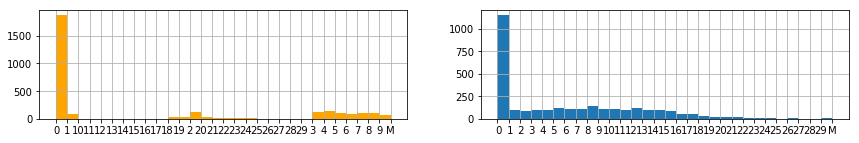

In [1052]:
dimm=(14.5,2)
plt.subplots(figsize=dimm)
plt.subplot(1,2,1)
weather['Heat'].hist(bins=30,color='orange')
plt.subplot(1,2,2)
weather['Cool'].hist(bins=30)

creating a dictionary "dic" for value_counts() to shorten the typing. the keys are the features' names' 

In [587]:
dic={}
for column in weather.columns:
    val=weather[column].value_counts()
    dic[column]=val

In [592]:
print(dic['CodeSum'].index[4],' - Meanning: TS-THUNDERSTORM,RA-RAIN,BR-MIST')
print(dic['CodeSum'][0:8])
print(type(weather['CodeSum'][2]))

TSRA RA BR  - Meanning: TS-THUNDERSTORM,RA-RAIN,BR-MIST
              1609
RA             296
RA BR          238
BR             110
TSRA RA BR      92
BR HZ           81
RA DZ BR        65
TSRA RA         43
Name: CodeSum, dtype: int64
<class 'str'>


In [594]:
dic['SnowFall'] # T means trace, amount that is very little (below measuring rate)

M      1472
0.0    1459
  T      12
0.1       1
Name: SnowFall, dtype: int64

Codes. almost all related to cold / wet / stormy weather. so effecting WNV. 1609 empty

In [607]:
dic['PrecipTotal'][:4]

0.00    1577
  T      318
0.01     127
0.02      63
Name: PrecipTotal, dtype: int64

T - Trace istoo little to measure. between 0.00 and 0.01 (we might convert it to 0.005):  

In [619]:
weather['PrecipTotal'][(weather['PrecipTotal']!='  T')&(weather['PrecipTotal']!='0.00')].min()

'0.01'

StnPressure (station pressure) - only 4 missing values.

In [630]:
weather['StnPressure'][weather['StnPressure']=='M']

87      M
848     M
2410    M
2411    M
Name: StnPressure, dtype: object

StnPressure - all is around 29 with range of 1.3, mean 29.3, std 0.16

In [637]:
print(dic['StnPressure'][:4]) 
print('range',np.ptp(weather['StnPressure'][weather['StnPressure']!='M'].astype(float)))
weather['StnPressure'][weather['StnPressure']!='M'].astype(float).apply([np.mean,np.std])

29.34    128
29.28    124
29.26    123
29.21    107
Name: StnPressure, dtype: int64
range 1.31


mean    29.284429
std      0.158543
Name: StnPressure, dtype: float64

SeaLevel (Pressure) - mean 29.3, std 0.16, range1.3, # of 'M' = 9

In [643]:
print('# of "M"',sum(weather['SeaLevel']=='M'))
print(dic['SeaLevel'][:4]) 
print('range',np.ptp(weather['SeaLevel'][weather['SeaLevel']!='M'].astype(float)))
weather['SeaLevel'][weather['SeaLevel']!='M'].astype(float).apply([np.mean,np.std])

# of "M" 9
30.00    96
29.94    85
29.98    85
29.92    83
Name: SeaLevel, dtype: int64
range 1.3


mean    29.968129
std      0.158597
Name: SeaLevel, dtype: float64

ResultSpeed - vector sum of windspeed and direction ( so the next 2 columns?). 

count    2944.000000
mean        6.960666
std         3.587527
min         0.100000
25%         4.300000
50%         6.400000
75%         9.200000
max        24.100000
Name: ResultSpeed, dtype: float64

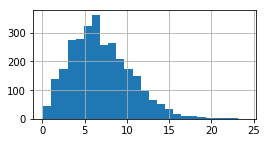

In [687]:
plt.subplots(figsize=[4,2])
weather['ResultSpeed'].hist(bins=25)
weather['ResultSpeed'].describe()

resultant direction - in tens of degrees (360 max)

count    2944.000000
mean       17.494905
std        10.063609
min         1.000000
25%         7.000000
50%        19.000000
75%        25.000000
max        36.000000
Name: ResultDir, dtype: float64

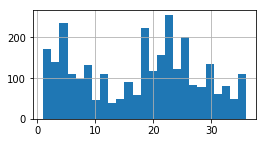

In [688]:
plt.subplots(figsize=[4,2])
weather['ResultDir'].hist(bins=25)
weather['ResultDir'].describe()

AvgSpeed - 3 missing, mean=8.5, std = 3, min=1.7,max= 26

In [680]:
print(dic['AvgSpeed'][dic['AvgSpeed'].index=='M']) ## 
print(dic['AvgSpeed'][:4])
weather['AvgSpeed'][weather['AvgSpeed']!='M'].astype(float).describe()

M    3
Name: AvgSpeed, dtype: int64
6.9    63
5.8    60
7.4    55
8.1    49
Name: AvgSpeed, dtype: int64


count    2941.000000
mean        8.580449
std         3.147300
min         1.700000
25%         6.300000
50%         8.100000
75%        10.400000
max        26.300000
Name: AvgSpeed, dtype: float64

##### end of weather features investigation

reminder of features:
    



In [433]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

#### summary of features - post some EDA 
( {-/+} means hypothetical correlation to WNV response) :
- Date - no null
- Dew point - is an accurate measurement of humidity (indipendant of Relative humidity) 60= uncomfortable, 70 very uncomfortable. {-}  
- Depart - Departure from normal expected (in temperatures) {?}
a lot of missing data (M)
- WetBulb - temps: the lower the dryer, "A lower wet bulb temperature means the air is drier {-}
- Heat and Cool - look like days in a month (mostly zero) {+/-} (maybe split)
- Sunrise - type 'str' alternating empty = '-' (half of data) 1472/2944{?} 
- Depth - of snow. all is Zero or M (NaN) (should drop)
- CodeSum -Codes. Type 'str'. almost all related to cold / wet / stormy weather (top 8 most prevalent). empty is ' ' 1609 out of 2944 {-/+} (maybe split) empty might be normal days that are {+}
- Water1 - All missing data (M) (should drop)
- Snow Fall - half missing (M), half 0.0, 12 are T = trace i.e. very low 1 is 0.1. (should drop)
- PrecipTotal - all numbers except "T" (type string). can convert to 0.005 {-}
- StnPressure (station pressure) - 4 missing ('M'), type 'str' all is around 29 with range of 1.3, mean 29.3, std 0.16 {+/-}
- SeaLevel (Pressure) - mean 29.3, std 0.16, range1.3, number of 'M' = 9 (normal is 29.92 inch at sea level) {+/-}
- ResultSpeed - vector sum of windspeed and direction ( so the next 2 columns?). (keep as that) {+/-} 
- resultant direction - in tens of degrees (360 max) (keep as that) {+/-}
- AvgSpeed - 3 missing, mean=8.5, std = 3, min=1.7,max= 26. lose "M" (median),  keep as that. {+/-}

In [690]:
dic.keys()

dict_keys(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed'])

In [755]:
# nulls={}
# for col in weather.columns:
#     print(col)
#     u=dic[col].index=='M'
#     print(u)
#     if u==False:
#         u=0
#         u.astype(float)
#         print(u)
#         print(sum(u))
#     if sum(u)==0:
#         print('No')
# # #         nulls=dic[col][dic[col].index=='M'][0]
# # #         print(nulls)
# # #         nulls[col]=null
# # #     else:
# # #         nulls[col]=0

### Adding weather dataset to the train dataset 

Method:
    - Add station column to train dataset according to geo-location:
    - merge weather and train datasets by date and station
following steps:
    - cleanning rows and columns (missing values, eliminating columns)
    - running a model for basic accuracy
    - balancing the classes in the dataset and then running new model
    - feature engineering, running model again

In [365]:
# Reminder the geo-location of the stations 
weather['Station'].unique()
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

array([1, 2])

##### Create weather station column in the train data (2 different stations: 1 and 2)
- first create a function to get classify which weather station fits which trap collection (by geo-location)

In [20]:
# assumption: long and lat have the same resolution when converted to distance.
# for distance calculation using: distance^2=long^2+lat^2

import random
def stationing(long,lat):
    sta1={'long':-87.933,'lat': 41.995}
    sta2={'long':-87.752,'lat': 41.786}
    longdelt1=long-sta1['long']
    latdelt1=lat-sta1['lat']
    dist1 = np.sqrt((longdelt1)**2+(latdelt1)**2)
    #print("dist1 =",dist1)
    longdelt2=long-sta2['long']
    latdelt2=lat-sta2['lat']
    dist2 = np.sqrt((longdelt2)**2+(latdelt2)**2)
    #print("dist2 =",dist2)
    if dist1<dist2:
        #print("stat1",dist1)
        station=1
    elif dist1>dist2:
        station=2
        #print("stat2",dist2)
    else:
        station=random.choice([1,2])
    return(station)

In [903]:
res6sta=res5.copy() # make a copy of res5 so we can add station column to it

In [904]:
res6sta['station']=res6sta.apply(lambda x: stationing(x.Longitude,x.Latitude),axis=1)  
## using stationing function (previous cells) to match station number to every observation

In [900]:
res6sta[res6sta.station==1][2000:2001] #  Let's look at a random row to see the station column

,Longitude,Latitude,min,max,most_recent_spray (days),Date_of_collection,Address,Block,Street,Trap,...,NumMosquitos,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,WnvPresent,Recently_sprayed,station
9620,-87.891,41.975,NaT,NaT,3650,2013-08-01,"ORD Terminal 5, O'Hare International Airport, ...",10,W OHARE AIRPORT,T900,...,3,0,1,0,0,0,0,0,0,1


In [905]:
res6sta['station'].value_counts()

2    8223
1    2283
Name: station, dtype: int64

now we have station column. ~80% of the traps are closer to station 2

##### Next, merge weather data with train data (res6sta)
Note: here we are merging the dfs, such that weather data date is aligned with the collection date (i.e. weather on the day of collection). Since trap collection is condcuted once a week, it would be more accurate to attend to the weather data throughout the whole week (e.g. by averaging across the days). For the time being we are skipping this step (leaving it as an option for feature engineering later).  

In [906]:
res6sta.loc[0,'Date_of_collection']

Timestamp('2007-07-02 00:00:00')

In [907]:
weather['Date']=pd.to_datetime(weather['Date'])

In [910]:
resWeath=res6sta.copy()

In [913]:
resWeath=pd.merge(res6sta,weather,left_on=['Date_of_collection','station'],right_on=['Date','Station'],how='left',indicator=True)

In [918]:
resWeath.station.value_counts()

2    8223
1    2283
Name: station, dtype: int64

##### Let's clean the merged data (with the summary of weather features done before) 

let's drop a few columns:

In [939]:
resWeath.drop(['station','Date'],1,inplace=True)

In [942]:
resWeath.drop(['_merge',],1,inplace=True)

In [944]:
resWeath.columns

Index(['Longitude', 'Latitude', 'min', 'max', 'most_recent_spray (days)',
       'Date_of_collection', 'Address', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'AddressAccuracy', 'NumMosquitos',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'WnvPresent',
       'Recently_sprayed', 'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart',
       'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum',
       'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [958]:
print(type(resWeath['Tmax'][0]))
resWeath['Tmax'].describe()# there are no missing values, Tmax is good to go.

<class 'numpy.int64'>


(count    10506.000000
 mean        81.947554
 std          8.288975
 min         57.000000
 25%         78.000000
 50%         83.000000
 75%         88.000000
 max         97.000000
 Name: Tmax, dtype: float64, 38)

In [959]:
# resWeath['Tmin'].value_counts()
print(type(resWeath['Tmin'][0]))
resWeath['Tmin'].describe()# there are no missing values, Tmin is good to go.

<class 'numpy.int64'>


count    10506.000000
mean        64.162003
std          7.530223
min         41.000000
25%         60.000000
50%         66.000000
75%         70.000000
max         79.000000
Name: Tmin, dtype: float64

In [962]:
# resWeath['Tmin'].value_counts()
print(type(resWeath['Tavg'][0]))
resWeath['Tavg'].describe()# there are no missing values. but type needs to change to int.

<class 'str'>


count     10506
unique       36
top          77
freq       1115
Name: Tavg, dtype: object

In [974]:
resWeath['Tavg']=resWeath['Tavg'].astype(int) # change to int
resWeath.loc[0,'Tmax':'Tavg'], (77+58)/2   ## checking that its around the average of max and min.
# Tavg good to go

(Tmax    77
 Tmin    58
 Tavg    68
 Name: 0, dtype: object, 67.5)

In [1003]:
#Depart:
print(type(resWeath.loc[0,'Depart']))
print(len(resWeath['Depart'][resWeath['Depart']=='M'])) # Most is M missing (8223). but maybe it's actually zero?
print(sum(resWeath['Depart'].value_counts().index==' 0')) # no there is zero. so M is missing.

<class 'str'>
8223
1


In [1005]:
# droping the Depart column:
resWeath.drop('Depart',1,inplace=True)

In [1010]:
#DewPoint:
print(type(resWeath.loc[0,'DewPoint']))
print(len(resWeath['DewPoint'].value_counts())) # there are no missing values, type int64. good to go. 

<class 'numpy.int64'>
36


##### WetBulb

In [1011]:
#WetBulb:
print(type(resWeath.loc[0,'WetBulb']))
print(len(resWeath['WetBulb'][resWeath['WetBulb']=='M'])) # 'M' missing (26). but maybe it's actually zero?

<class 'str'>
26


Since number of missing values are small (26), mode or median would make sense as replacement.
But after doing quick search online, we can approximate WetBulb from DewPoint and temperature (that we have) with this formula - TAVG-((TAVG-DEWPOINT)/3). 
(resource: http://theweatherprediction.com/habyhints/170/ )

Let's see if approx works on already known WetBulb'

In [1013]:
resWeath.loc[0:2,'Tavg':'WetBulb']

,Tavg,DewPoint,WetBulb
0,68,50,59
1,68,50,59
2,77,69,71


In [56]:
# Writing a function for the approx:
def wetbulb(tavg,dp,wb):
    if wb=='M':
        wb=tavg-(tavg-dp)/3
    else: 
        pass
    return(wb)

In [57]:
wetbulb(68,50,'M'),wetbulb(77,69,'M')  

(62.0, 74.33333333333333)

so ~3 points away. 

just for curiosity, how much mode is away?

In [1019]:
resWeath['WetBulb'][resWeath['WetBulb']!='M'].mode()

0    62
dtype: object

By using mode we get 3 points and 12 pts away.

Approx is more sensitive, let's use its function:

In [ ]:
resWeath['WetBulb'][resWeath['WetBulb']=='M'].index # let's do a trial 1st before ammending the whole df :

In [1023]:
trial=resWeath.loc[534:538,'Tavg':'WetBulb']
trial

,Tavg,DewPoint,WetBulb
534,76,67,69
535,76,67,69
536,78,60,M
537,78,60,M
538,78,60,M


In [1026]:
trial['WetBulb']=trial.apply(lambda x: wetbulb(x['Tavg'],x['DewPoint'],x['WetBulb']),axis=1)

In [1027]:
trial

,Tavg,DewPoint,WetBulb
534,76,67,69
535,76,67,69
536,78,60,72
537,78,60,72
538,78,60,72


works well on trial, let's apply it to the whole df:

In [1028]:
resWeath['WetBulb']=resWeath.apply(lambda x: wetbulb(x['Tavg'],x['DewPoint'],x['WetBulb']),axis=1)

In [1037]:
resWeath['WetBulb']=resWeath['WetBulb'].astype(int) ## now type int, no missing values. good to go.
resWeath['WetBulb'].describe()

count    10506.000000
mean        64.918047
std          6.697236
min         46.000000
25%         61.000000
50%         66.000000
75%         70.000000
max         76.000000
Name: WetBulb, dtype: float64

Heat

In [1043]:
resWeath['Heat']=resWeath['Heat'].astype(int)
resWeath['Heat'].describe() # now type int, no missing values. good to go.

count    10506.000000
mean         0.850466
std          2.640404
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Heat, dtype: float64

Cool

In [1054]:
resWeath['Cool']=resWeath['Cool'].astype(int)
resWeath['Cool'].describe() # now type int, no missing values. good to go.

count    10506.000000
mean         9.133162
std          5.791973
min          0.000000
25%          5.000000
50%         10.000000
75%         14.000000
max         22.000000
Name: Cool, dtype: float64

In [1062]:
resWeath['Sunrise'].value_counts()[0:3] # mostly empty, let's drop the column
resWeath['Sunset'].value_counts()[0:3] # mostly empty, let's drop the column

In [1059]:
resWeath.drop(['Sunrise','Sunset'],1,inplace=True)

CodeSum

In [1112]:
# All codes Depict stormy "bad" weather. let's split the column to normal (i.e. missing ' ') and bad.
# assumption - thunderstorm is wet weather. although in reality , it could be dry weather as well. nevertheless chose to categorize it as bad.
codes=resWeath['CodeSum'].value_counts()
codes[0:4]

                 6001
RA                666
RA BR             524
TS TSRA RA BR     463
Name: CodeSum, dtype: int64

In [1099]:
resWeath['CodeSum'][resWeath['CodeSum']==' '][1]

' '

In [1106]:
resWeath['CodeSum'][resWeath['CodeSum']==' '][0:3]

0     
1     
5     
Name: CodeSum, dtype: object

function for categorizing codes to 2 groups

In [1107]:
def codes(col):
    if col==' ':
        col='Norm'
    else:
        col='Bad'
    return(col)
codes(' ')

'Norm'

In [1108]:
resWeath['weather_type']=resWeath.apply(lambda x: codes(x['CodeSum']), axis=1)

In [1113]:
resWeath['weather_type'].value_counts()

Norm    6001
Bad     4505
Name: weather_type, dtype: int64

In [1114]:
resWeath=pd.get_dummies(resWeath,columns=['weather_type'],drop_first=True)

In [1120]:
resWeath.weather_type_Norm.value_counts()

1    6001
0    4505
Name: weather_type_Norm, dtype: int64

In [1124]:
resWeath.drop(['Water1','SnowFall'],1,inplace=True) ## see summary, mostly missing values

PrecipTotal

convert T (trace) to 0.005 (look at summary):

In [1150]:
resWeath['PrecipTotal']=resWeath['PrecipTotal'].apply(lambda x: 0.005 if x=='  T' else x)

In [1155]:
sum(resWeath['PrecipTotal']==0.005), sum(resWeath['PrecipTotal']=='M')

(839, 35)

In [19]:
#convert 'M' to mode 
import statistics as st
mode=st.mode(resWeath['PrecipTotal']) # mode is '0'
resWeath['PrecipTotal']=resWeath['PrecipTotal'].apply(lambda x: mode if x=='M' else x)

In [1180]:
resWeath['PrecipTotal']=resWeath['PrecipTotal'].astype(float) # converting to type float.
type(resWeath['PrecipTotal'][0])    # good to go

Depth

In [1184]:
resWeath.drop('Depth',inplace=True,axis=1) # drop, mostly 'M' rest 0 (see summary)

StnPressure, SeaLevel

In [1203]:
sum(resWeath['StnPressure']=='M')

0

In [1202]:
moud=st.mode(resWeath['StnPressure'])
resWeath['StnPressure']=resWeath['StnPressure'].apply(lambda x: moud if x=='M' else x)
resWeath['StnPressure'].value_counts()[:2]

29.34    1322
29.18     526
Name: StnPressure, dtype: int64

In [1208]:
resWeath['StnPressure']=resWeath['StnPressure'].astype(float)
resWeath['StnPressure'].describe() 
type(resWeath['StnPressure'][0])### good to go 

numpy.float64

In [1209]:
resWeath['SeaLevel']=resWeath['SeaLevel'].astype(float)
resWeath['SeaLevel'].describe()
type(resWeath['StnPressure'][0]) ## good to go 

numpy.float64

'ResultSpeed', 'ResultDir', 'AvgSpeed'

In [1219]:
## 'ResultSpeed', 'ResultDir' are good to go (floats no missing value)
resWeath['AvgSpeed']=resWeath['AvgSpeed'].astype(float) # turn to float
resWeath['AvgSpeed'].describe() ## good to go

count    10506.000000
mean         7.459290
std          2.516721
min          2.100000
25%          5.800000
50%          7.100000
75%          9.200000
max         16.300000
Name: AvgSpeed, dtype: float64

date of colletion

### Features Ready

Finally, let's drop unnecessary/impossible columns for analysis and create the features!

In [1279]:
features=resWeath.copy()

In [1314]:
features.drop(['min','max','Date_of_collection','Address','Street','Trap','AddressNumberAndStreet','CodeSum'],axis=1,inplace=True)

In [1318]:
len(resWeath.columns),len(features.columns)

(41, 33)

let's save the resWeath df as csv so can get read it in when we please.

In [1064]:
#rep path:
repath="/Users/eran/Galvanize_more_repositories/WestNileVirus/"

In [1612]:
if 1==0:
    features3.to_csv(os.path.join(repath,'features3.csv'),)
    # TRY index=False to avoid creating a column of indices
## turn the statement to true in order to save the it the file again.

"most recent spray (days)" feature is really effecting the feature space (because of the majority of fabricated 3500 days). let's turn this column into 3 categories: recently sprayed (this season <180 days), sprayed 2 yrs ago, and never sprayed (=3650).

In [1536]:
mid=features['most_recent_spray (days)'][(features['most_recent_spray (days)']<3650)&(features['most_recent_spray (days)']>180)]
min(mid),max(mid),np.ptp(mid)

(639, 750, 111)

In [1538]:
min(mid)/365,max(mid)/365  ## ~ 2 years 

(1.7506849315068493, 2.0547945205479454)

In [1537]:
features2=features.copy()

In [1548]:
features2['sprayed_2_yrs_ago']=features2['most_recent_spray (days)'].apply(lambda x: 1 if sum(x==mid)>0 else 0)

In [1555]:
features2['never_sprayed']=features2['most_recent_spray (days)'].apply(lambda x: 1 if x>3640 else 0)

In [1555]:
features2['never_sprayed']=features2['most_recent_spray (days)'].apply(lambda x: 1 if x>3640 else 0)

In [1596]:
fcols=list(features2.columns)
fcols[-1]
fcols1=fcols[:12]+[fcols[-2]]+[fcols[-1]]+fcols[13:-2]+[fcols[12]]

In [1599]:
features3=features2[fcols1]

In [1608]:
features3['year']=features3['year']-min(features3.year)+1

In [1609]:
features3['year'].value_counts()

1    3811
7    2392
3    2249
5    2054
Name: year, dtype: int64

In [1610]:
features3.drop(['most_recent_spray (days)'],axis=1,inplace=True)

In [1612]:
if 1==0:
    features3.to_csv(os.path.join(repath,'features3.csv'))
## turn the statement to true in order to save the file.

In [6]:
if 1==0:
    features3=pd.read_csv("/Users/eran/Galvanize_more_repositories/WestNileVirus/features3.csv")
## turn the statement to true in order to load the file again

# # #

### Baseline Modelling 
Baseline modeling (KNN) (after feature engineering and before oversampling, model selection and tweaking of hyperparameters 

In [32]:
Xtrain,Xtest,ytrain,ytest=train_test_split(features3.drop('WnvPresent',1),features3['WnvPresent'],test_size=0.2,random_state=42,stratify=features3['WnvPresent'])

In [35]:
clf=KNeighborsClassifier(n_neighbors=5)
clf.fit(Xtrain,ytrain)
ypred=clf.predict(Xtest)
print(confusion_matrix(ytest,ypred))
print(classification_report(ytest,ypred,target_names=target_names))

[[1982   10]
 [ 107    3]]
              precision    recall  f1-score   support

    No Virus       0.95      0.99      0.97      1992
       Virus       0.23      0.03      0.05       110

   micro avg       0.94      0.94      0.94      2102
   macro avg       0.59      0.51      0.51      2102
weighted avg       0.91      0.94      0.92      2102



# # # # # # # # 

##### K neighbors

In [39]:
knnsmt=KNeighborsClassifier(n_neighbors=5)
knnsmt.fit(smtXtrain,smtytrain)
smtypred=knnsmt.predict(Xtest)

In [15]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [40]:
#print(classification_report(smtypred,ytest,target_names=target_names))
print('______________')
print('')
print('KNearest (k=5)')
print('______________')
print(confusion_matrix(smtypred,ytest))
print("accuracy:")
print(accuracy_score(smtypred,ytest))
print("recall:")
print(recall_score(smtypred,ytest))
print("precision:")
print(precision_score(smtypred,ytest))

______________

KNearest (k=5)
______________
[[1668   52]
 [ 324   58]]
accuracy:
0.8211227402473834
recall:
0.1518324607329843
precision:
0.5272727272727272


In [41]:
recscore=[]
accurscore=[]
prescore=[]
k=list(range(1,25))
for i in k:
    knnn=KNeighborsClassifier(n_neighbors=i)
    knnn.fit(smtXtrain,smtytrain)
    yypred=knnn.predict(Xtest)
    prescore.append(precision_score(yypred,ytest))
    recscore.append(recall_score(yypred,ytest))
    accurscore.append(accuracy_score(yypred,ytest))

Text(0,0.5,'precision')

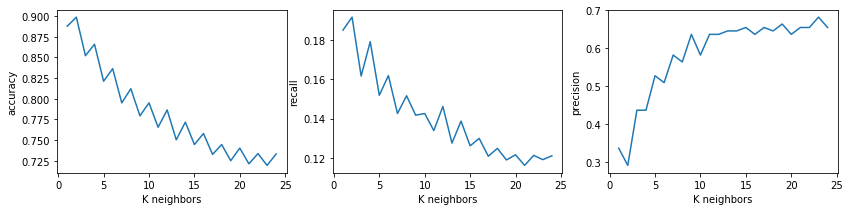

In [42]:
plt.subplots(figsize=(14,3))
plt.subplot(1,3,1)
plt.plot(k,accurscore)
plt.xlabel('K neighbors')
plt.ylabel('accuracy')
plt.subplot(1,3,2)
plt.plot(k,recscore)
plt.xlabel('K neighbors')
plt.ylabel('recall')
plt.subplot(1,3,3)
plt.plot(k,prescore)
plt.xlabel('K neighbors')
plt.ylabel('precision')

# # # # # # # # 

## Train Data EDA

In [705]:
train2=train1.copy()
train2['month']=train1['Date'].apply(lambda x: x.to_pydatetime().month)
train2['year']=train1['Date'].apply(lambda x: x.to_pydatetime().year)
train2['Day_of_week']=train1['Date'].apply(lambda x: x.to_pydatetime().weekday())

(<matplotlib.axes._subplots.AxesSubplot at 0x1a4d7f0940>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a4d7f0940>)

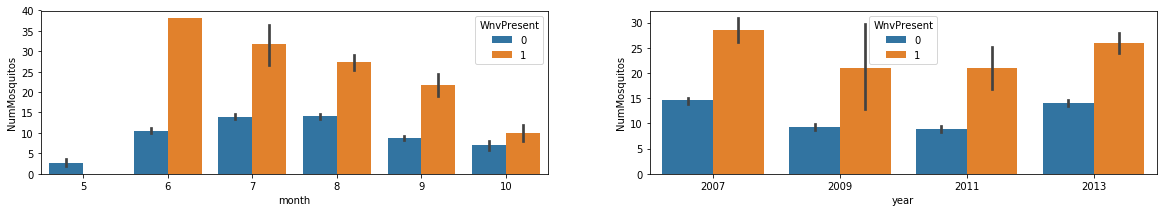

In [723]:
## train 
plt.subplots(figsize=(20,3))
plt.subplot(1,2,1),sns.barplot('month','NumMosquitos',data=train2,hue='WnvPresent')  #,fit_reg=False
plt.subplot(1,2,2),sns.barplot('year','NumMosquitos',data=train2,hue='WnvPresent')  #,fit_reg=False

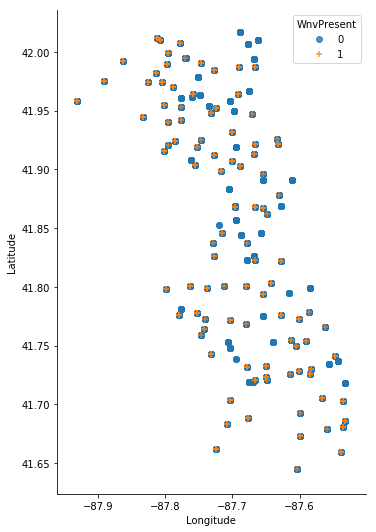

In [763]:
sns.lmplot('Longitude','Latitude',data=train2,hue='WnvPresent',fit_reg=False,markers=['o','+'],height=7.5,aspect=0.71,legend_out=False)

Using Ad Hoc function to plot WHERE and WHEN traps were collected, and which of the had the VIRUS?

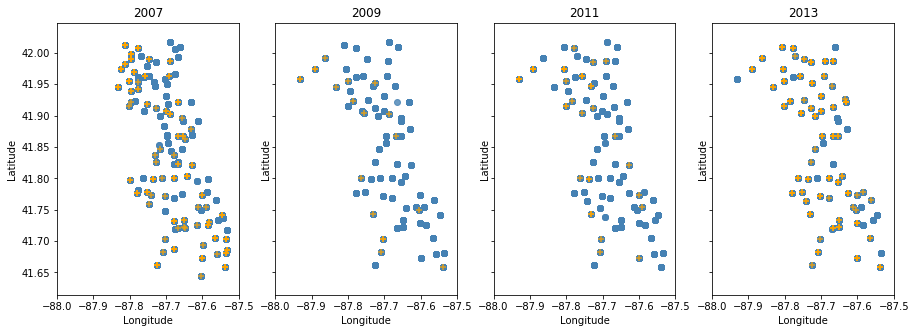

In [899]:
pltloglat(year) ## look at WNVdataEng for documentation

Year - 2007


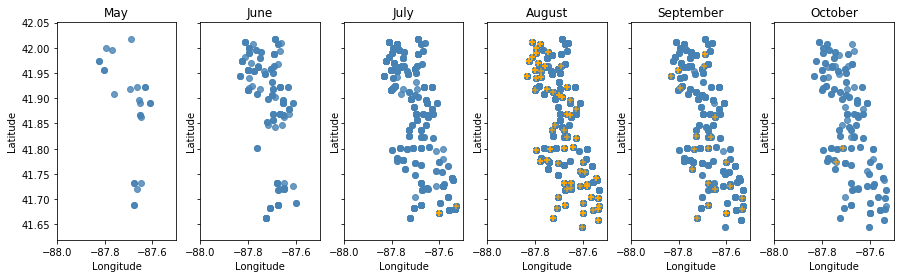

In [898]:
pltloglat(month,yearr=2007) ## look at WNVdataEng for documentation

In [849]:
month=['May','June','July', 'August','September','October']
range(len(month))
month[0]

'May'

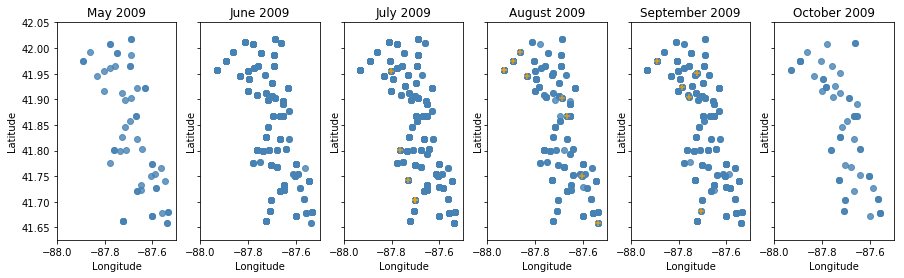

In [835]:
fig,(ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=1,ncols=6, sharey=True)
fig.set_size_inches(15, 4)
ax1.set_title('May 2009')
ax2.set_title('June 2009')
ax3.set_title('July 2009')
ax4.set_title('August 2009')
ax5.set_title('September 2009')
ax6.set_title('October 2009')
ax1.set_xlim([-88.0,-87.5])
ax2.set_xlim([-88.0,-87.5])
ax3.set_xlim([-88.0,-87.5])
ax4.set_xlim([-88.0,-87.5])
ax5.set_xlim([-88.0,-87.5])
ax6.set_xlim([-88.0,-87.5])
sns.regplot('Longitude','Latitude',data=train2009_5_0,fit_reg=False,ax=ax1,color='steelblue')
sns.regplot('Longitude','Latitude',data=train2009_5_1,fit_reg=False,ax=ax1,color='orange',marker='+',)
sns.regplot('Longitude','Latitude',data=train2009_6_0,fit_reg=False,ax=ax2,color='steelblue')
sns.regplot('Longitude','Latitude',data=train2009_6_1,fit_reg=False,ax=ax2,color='orange',marker='+',)
sns.regplot('Longitude','Latitude',data=train2009_7_0,fit_reg=False,ax=ax3,color='steelblue')
sns.regplot('Longitude','Latitude',data=train2009_7_1,fit_reg=False,ax=ax3,color='orange',marker='+',)
sns.regplot('Longitude','Latitude',data=train2009_8_0,fit_reg=False,ax=ax4,color='steelblue')
sns.regplot('Longitude','Latitude',data=train2009_8_1,fit_reg=False,ax=ax4,color='orange',marker='+')
sns.regplot('Longitude','Latitude',data=train2009_9_0,fit_reg=False,ax=ax5,color='steelblue')
sns.regplot('Longitude','Latitude',data=train2009_9_1,fit_reg=False,ax=ax5,color='orange',marker='+')
sns.regplot('Longitude','Latitude',data=train2009_10_0,fit_reg=False,ax=ax6,color='steelblue')
sns.regplot('Longitude','Latitude',data=train2009_10_1,fit_reg=False,ax=ax6,color='orange',marker='+')

## Spray Data EDA

## Weather Data EDA

Inorder to uncover relationships between weather variables and WNV response, several steps should be performed (Unlike with clean, and organized data such as train.csv):
    
* Weather data should be cleaned (refer to "weather" as the raw data and "weath_out" as clean data)
* weather data should be merged with train data in order to couple it with WNV response (refer to "sptrainW_day_of")
* Weather data should be processed in a sensible way by producing features that would offer added information, based on a rational e.g. mosquitos need continous dry and hot weather inorder to thrive so features should be summarized in segments of time e.g. 2 weeks. (refer to "eng_weath" as the engineered weather data, and to "sptrainW_14_day" as the engineered and merged data with train data)  

#### summary of features - post some EDA 
( {-/+} means hypothetical correlation to WNV response) :
- Dew point - is an accurate measurement of humidity (indipendant of Relative humidity) 60= uncomfortable, 70 very uncomfortable. {-}  
- Depart - Departure from normal expected (in temperatures) {?}
a lot of missing data (M)
- WetBulb - temps: the lower the dryer, "A lower wet bulb temperature means the air is drier {-}
- Heat and Cool - look like days in a month (mostly zero) {+/-} (maybe split)
- Depth - of snow. all is Zero or M (NaN) (variable should drop)
- CodeSum -Codes. Type 'str'. almost all related to cold / wet / stormy weather (top 8 most prevalent). empty is ' ' 1609 out of 2944 {-/+} (maybe split) empty might be normal days that are {+}
- PrecipTotal - all numbers except "T" (type string). can convert to 0.005 {-}
- ResultSpeed - vector sum of windspeed and direction. (keep as is) {+/-} 
- resultant direction - in tens of degrees (360 max) (keep as is) {+/-}
- AvgSpeed - 3 missing, use median to fill in the nissing values. (rest keep as is). {+/-}

### Weather Feature Engineering

In [589]:
# turn the expression into True to run the cell:
if 1==0:
    %run /Users/eran/Galvanize_more_repositories/WestNileVirus/WNVdataENG.py

Using get_summary function to feature engineer a variable:

* choosing a variable to engineer - e.g. 'ResultSpeed' - wind speed 
* getting a set of consecutive days data of that variable (e.g. 10) 
* creating the following summary:
    mean, std, median and outliers. The rational is that even one day of abnormal weather can effect the resulting mosquito population and therefore the WNV response.

In [587]:
get_summary(weather.loc[0:10,'ResultSpeed'])  ## look at func documentation in WNVdataENG.py

,ResultSpeed.mean,ResultSpeed.std,ResultSpeed.50%,ResultSpeed.mean-median,ResultSpeed.outliers_low,ResultSpeed.outliers_high
0,10.281818,4.19948,11.7,-1.418182,1,0


TOP

Example shows: outlier_low = 1 shows that there has been one abnormaly low wind day in the 10 day batch (calculated by z-score<-2)

'make_features' func

* takes weather data and creates features
* func is built on 'get_summary' func, to run through features of interest to create new features from them. 
* In our case the new features will be a summary of 14 days prior to trap collection, per variable. 
* for make features func documentation, look at WNVdataENG.py

features of interest:

In [588]:
int_feat=['Tmax', 'Tmin', 'Tavg', 'DewPoint', 
          'WetBulb','Heat', 'Cool', 'PrecipTotal', 'StnPressure',
          'ResultSpeed','ResultDir', 'AvgSpeed', 'weather_type_Norm']

Run the function to feature engineer weather data:

In [199]:
## warnning: this could take a while (approx 241 seconds)
## turn statement into True to run the function
if 1==0:
    eng_weath=make_features(weath_out,int_feat) 

## consolidating a final dataset for modelling:
* Merging "spray","train" and "14_day_Weather" data into 1 data set: 'sptrainW_14_days' (i.e. 'sp' + 'train' + 'W_14_day')
* merging the weather with train data according to 'weather station' and 'date of collection'
* saving the final dataset - '/Users/eran/Galvanize_more_repositories/WestNileVirus/sptrainW_14_days.csv'
* For all data engineering documentation - see WNVdataEng.py

In [609]:
os.path.join(directory_path,'sptrainW_14_days.csv')

'/Users/eran/Galvanize_more_repositories/WestNileVirus/sptrainW_14_days.csv'

### Finaly..
After consolidating, let's see if we can uncover interesting relationships between some features and WNV response

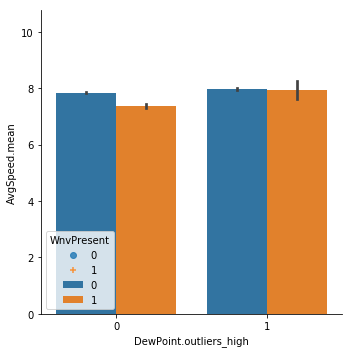

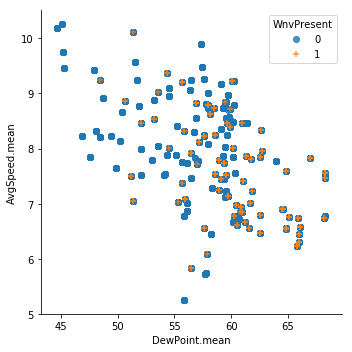

In [842]:
sns.lmplot('Tmax.mean','AvgSpeed.mean',data=sptrainW_14_days,hue='WnvPresent',fit_reg=False,markers=['o','+'],legend_out=False)
sns.barplot('DewPoint.outliers_high','AvgSpeed.mean',data=sptrainW_14_days,hue='WnvPresent')
sns.lmplot('DewPoint.mean','AvgSpeed.mean',data=sptrainW_14_days,hue='WnvPresent',fit_reg=False,markers=['o','+'],legend_out=False)

## Dimentionality Reduction visualization 
to visualize the feature space dependant WNV response

In [591]:
from sklearn.decomposition import PCA

In [605]:
pca=PCA(n_components=2)
pcaX=pca.fit_transform(sptrainW_14_days.drop(['WnvPresent','most_recent_spray_(days)'],1))
pcay=sptrainW_14_days['WnvPresent']
pcay.shape,pcaX.shape

((9296,), (9296, 2))

In [604]:
pcaXdf=pd.DataFrame(pcaX)
pcadf=pcaXdf.copy()
pcadf['pcay']=pcay
pcadf.rename(columns={0:'x0',1:'x1','pcay':'WNV_present'},inplace=True)

Text(0.5,1,'PCA (2 components)')

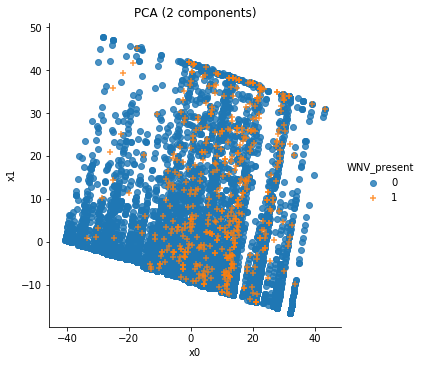

In [603]:
sns.lmplot('x0','x1',data=pcadf,hue='WNV_present',fit_reg=False,markers=['o','+'])
plt.title('PCA (2 components)')

* We can see that there isn't a definitive cluster of WNV response. However there is a higher frequency of WNV response in middle of the 2D space 
* Regardless, the graph is only for visualization purposes and therefore no conclusions could be drawn from it

### Dealling with the imbalnced data set
* Final step before modelling. 
* WNV occurence is scarce ~5%. This means that even a 'dumb model' of always predicting WNV=0, will achieve 95% accuracy.
* 'recall' and 'precision' and other metrics are a better fit, we'd be using them to test our model's performance
* Still, inorder to train our model a 5% minority response is not enough. Any given model would not be able to learn from it due to the overpowering effect of the majority of the data set
* There are several strategies to balance a dataset in order to train it, we will chose SMOTE

#### SMOTE
* Synthetic Minority Oversampling Technic (SMOTE)
* Using KNN to fabricate additional train data
* Spliting to train and test data first, and then using smote only on train data to avoid leakage of similar fabricated observations both in the train and the test (thus avoiding overfitting) 

In [16]:
from imblearn.over_sampling import SMOTE

ytrain imbalanced:


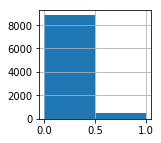

In [646]:
print('ytrain imbalanced:')
X_train=sptrainW_14_days.drop(['WnvPresent'],1)
y_train=sptrainW_14_days['WnvPresent']
p=y_train.hist(figsize=(2,2),bins=2)

ytrain balanced:


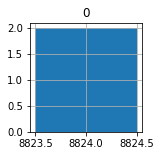

In [671]:
smt=SMOTE(random_state=42)
smtXtrain,smtytrain=smt.fit_sample(X_train,y_train)
print('ytrain balanced:')
p=pd.DataFrame(np.bincount(smtytrain)).hist(figsize=(2,2),bins=1)

# Modeling of the final engineered data
(with 14 day summary of weather till collection)

In [461]:
 # turn the expression into True to run the cell:
if 1==0:
    %run /Users/eran/Galvanize_more_repositories/WestNileVirus/WNVmodeling.py

The file: runs 3 models with arbitrary fixed hyperparameters (just to get a sense of performance)

* log_reg 
* KNN
* Random Forest Classifier)

on 4 different datasets (to see the effect of feature engineering on performance):

* 'baseline.imbalanced' that is cleaned train data with no engineering
* 'baseline that its minority response (WNV=1) is balanced to 1:1 ratio (using SMOTE)
* 'sptrainW_day_of' is enriched balanced train data (i.e. spray + train + weather data, where every observation (trap collection) is enriched with the weather of the same day
* 'sptrainW_14_day' same as 'sptrainW_day_of' where every observation is enriched with the summary of weather of the previous 2 weeks before collection.

It summarizes results with different metrics. we'll concentrate on AUC onder the ROC curve (AUCROC) and Recall. 

In [ ]:
oy=sss.T ## the df of metrics  (from file)
oy

(<matplotlib.axes._subplots.AxesSubplot at 0x1a32322320>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a32322320>)

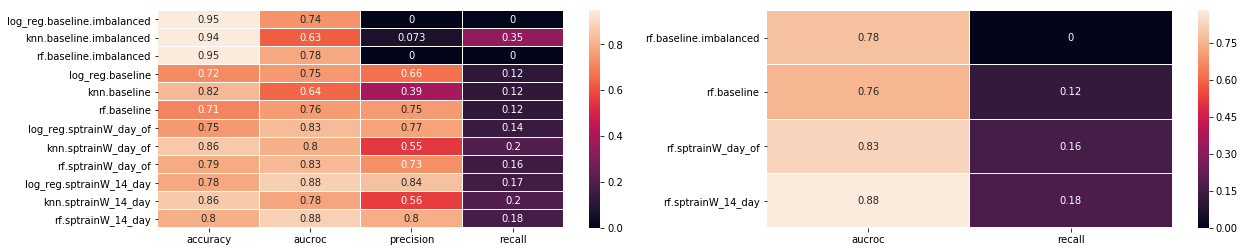

In [491]:
plt.subplots(figsize=(20,4))
plt.subplot(1,2,1),sns.heatmap(oy.loc[:,'accuracy':'recall'],linewidths=.05,annot=True)
plt.subplot(1,2,2),sns.heatmap(oy.iloc[[2,5,8,11],[5,7]],linewidths=.05,annot=True)

* TOP LEFT: Typical high accuracy of imbalanced (top left) is apperant together with zero precision and recall (top right). algorthm of "allways predict WNV=0" achieves same result
* TOP RIGHT: Gradually improved AUC and recall with feature engineering, looking at Random Forest only (Note recall is still very low) 

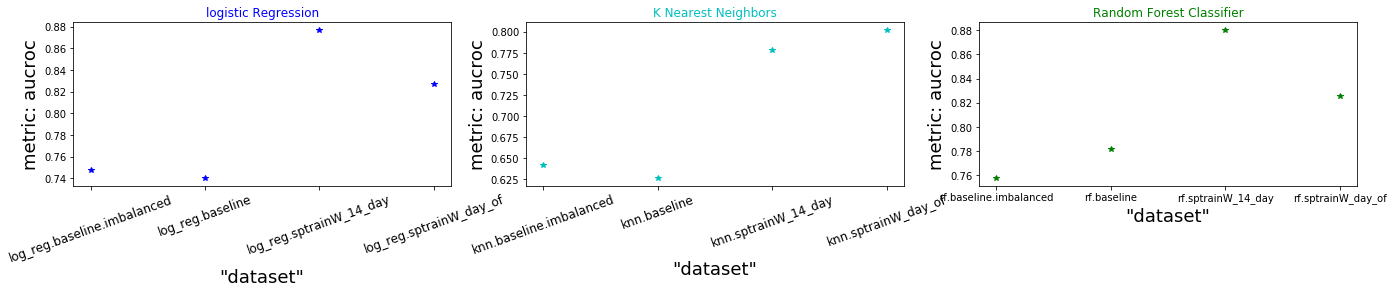

In [494]:
plt_met(mett='aucroc') ## look at func documaentation in WNVmodeling.py

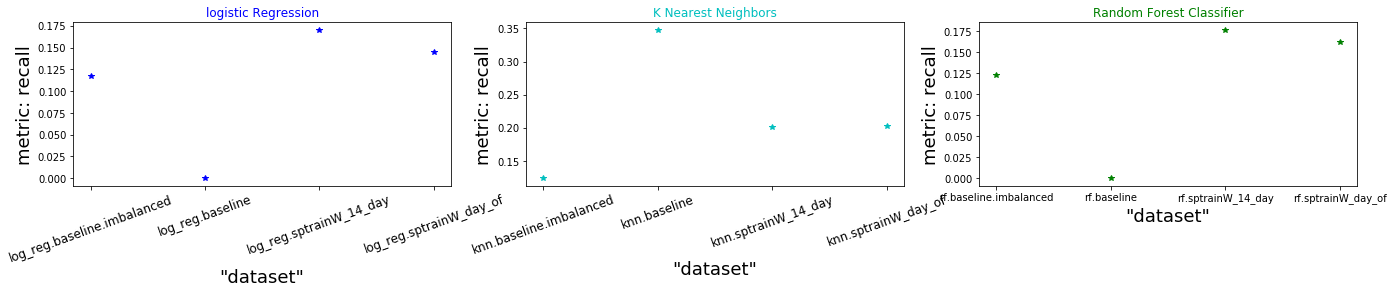

In [495]:
plt_met(mett='recall')

TOP: Best AUC and recall are acheived with the most engineered dataset (except when using KNN)

### Optimizing Hyperparameters:
continuing with the most engineered dataset (i.e. sptrainW_14_day) to optimize hyperparameters.

* using RF classifier - Although it is not better than Logistic Regression in performance, 
there are more hyperparameters that could be tuned to increase its perfomance.

Using Grid Search and Ad Hoc function 'grid_func': 
* to tune model for best recall, even on the expense of lowering precision (which is currently relatively high). This is because we care more about retrieving most WNV cases rather than avoid - Falsely predicting WNV. (For the purposes of Chicago minicipality the cost of missing a WNV case is much higher (due to health implications) than spraying an area falsly due to a mistake in WNV detection/prediction) 
* to tune model for best AUC ROC, we'll set our winning model on this result. AUC is superior because it will give us a score across all FP rate that we choose and therefore it is more robust (rather than a specific FPr score e.g. for a high recall) 

In [497]:
if 1==0:  
    GSrfRecall=grid_func('recall_score','sptrainW_14_day')  ## look at func documaentation in WNVmodeling.py
    GSrfAUC=grid_func('aucroc_score','sptrainW_14_day')

best params for aucroc_score
{'max_depth': 5, 'max_features': 20, 'min_samples_split': 3, 'n_estimators': 500}
confusion matrix adjusted for max aucroc_score
[[1519   23]
 [ 247   71]]


In [607]:
resultRec=pd.DataFrame(GSrfRecall.cv_results_)
resultAUC=pd.DataFrame(GSrfAUC.cv_results_)
### the best auc score placement in result df:
roww0=np.where(resultRec['mean_test_recall_score']==max(resultRec['mean_test_recall_score']))
roww1=np.where(resultAUC['mean_test_aucroc_score']==max(resultAUC['mean_test_aucroc_score']))
### give the winning row for highest AUC:
winRecallresult=resultRec.loc[roww0[0],[ 'mean_test_aucroc_score','mean_test_recall_score','mean_test_precision_score', 'mean_test_accuracy_score','param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']]
winAUCresult=resultAUC.loc[roww1[0],[ 'mean_test_aucroc_score','mean_test_recall_score','mean_test_precision_score', 'mean_test_accuracy_score','param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']]
winAUCresult.reset_index(inplace=True)
print('Best AUC score achieved:',round(winAUCresult['mean_test_aucroc_score'],2))
print('___________________________________')
print('Hyperparameters for best AUC score:')
winAUCresult[['param_max_depth','param_max_features','param_min_samples_split','param_n_estimators']]

Best AUC score achieved: 0    0.89
Name: mean_test_aucroc_score, dtype: float64
___________________________________
Hyperparameters for best AUC score:


,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
0,5,20,3,500


### Let's use these 'winning' parameters to run a RF model again, for further data analysis

In [531]:
rfwin=RandomForestClassifier(random_state=42,n_estimators=500,min_samples_split=3,max_features=20,max_depth=5)
rfwin.fit(Xtrain,ytrain)
predy=rfwin.predict(Xtest)
predprob=rfwin.predict_proba(Xtest)
fpr, tpr, thresholds = roc_curve(ytest, predprob[:,1])
precision, recall, threshol=precision_recall_curve(ytest, predprob[:,1])

roc_auc_score:  0.89
precision-recall_auc_score:  0.337


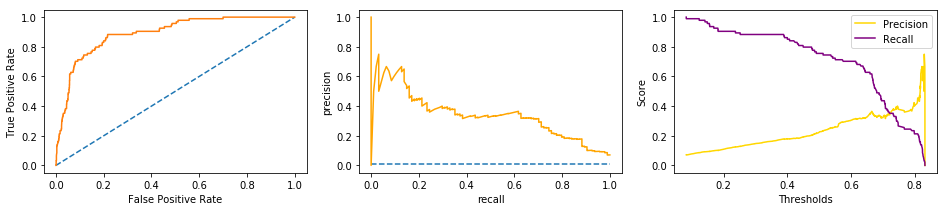

In [585]:
plt_curvs(ytest, predprob) ## look at func documentation in WNVmodeling.py

TOP-LEFT:
* Since we are interested in high recall rather then precision, we can choose a relatively high FP rate to (around 0.5, after th peak)

TOP-RIGHT:
* SImilarly threshold we can pick is 0.4 where recall is above 0.8 while precision is 0.2

### Feature importance:

* out of 90+ features, let's choose the ones with the strongest effect on WNV response 
* we choose a threshold of 0.01 to display ( to avoid showing all +90 features)

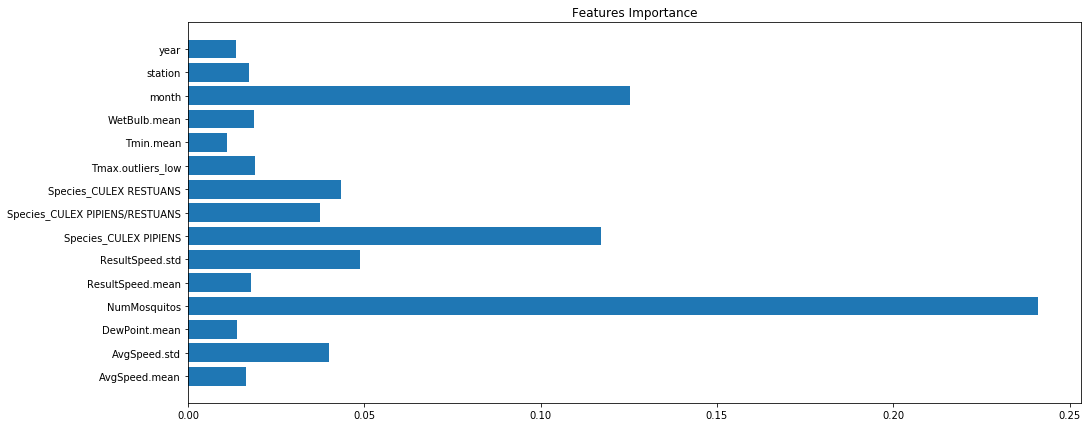

In [567]:
most=rfwin.feature_importances_[rfwin.feature_importances_>0.01]
collnum=np.where(rfwin.feature_importances_>0.01)
coll=sptrainW_14_days.drop('WnvPresent',1).columns[collnum]
plt.subplots(figsize=(16,7))
plt.barh(coll,most,)
j=plt.title('Features Importance')

#### Feature importance discussion:
    
* NumMosquitos, unsurprisingly nost important feature
* whether the specie is CULEX_PIPIENS or not, and the month in the year (e.g. summer) are also, unsurprisingly important
* From weather data, wind speed seems most important (probably strong winds effect the mosquitos)
* Humidity metrics have similar importance: i.e. wetbulb and dewpoint
* Cold metrics - if one of the days in the 2 weeks summarized had an extraordinary low 'Tmax' (Tmax.outliers.low), that probably lowered the chances for mosquitos
* Interestingly, there are definitly more occurences in specific areas in Chicago as could be infered from the station feature
* finally, some years have more occurences then other years

#### To make better sense of the effect these features have on WNV response, let's plot a heatmap of corelations. This way we'd be able to see the directionality of the correlation

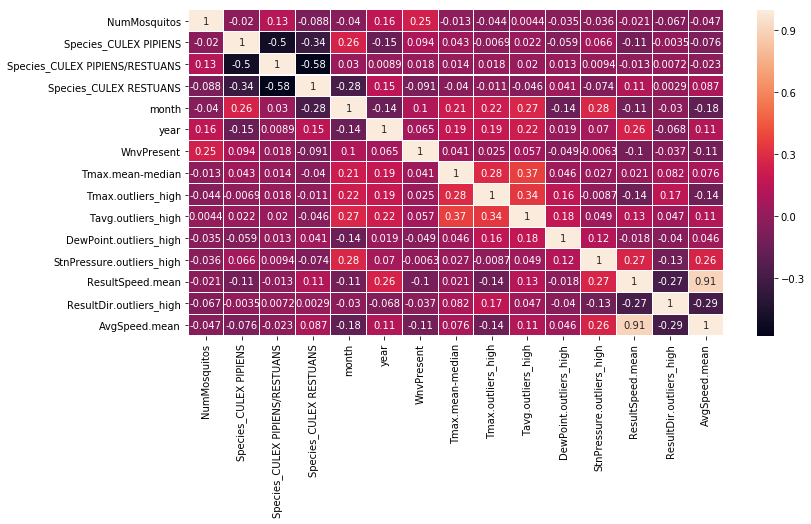

In [583]:
plt.subplots(figsize=(12,6))
collname=list(sptrainW_14_days.columns[collnum])
sns.heatmap(sptrainW_14_days[collname].corr(),linewidths=.05,annot=True)

TOP

* Indeed, all paraeters, regarding wind have negative correlation with WNV response meanning: More WINDY -> Less WNV.
* Dewpoint as well - More HUMID -> Less WNV (which is aligned with known facts about WNV that prefers dry conditions)
* Culex_Pipiens - most indicative of WNV response, Culex Restuans indicative of NO-WNV

- averaging weather data for a week/2 weeks before the collection (observation)
- repeat cleanning for test data ( make function: shit data in ready data out) (reintroduce sunrise/sunset)
- show effect of features engineering and re-balancing of the dasta set
PPT
- Nice EDA. hypothesis. feature engineering
- Explain Recall importance
- Enrich data with maps info on long-lat (e.g. swamp etc..)
- adjust weather info (mean weather for a week before)
- time series modeling? data set for every year?
- look at correlation between species. is there an actionable conclusion? releasing species that don't cary WNV to take the place of the others?